In [3]:
from ponyge2_adapted_files import Grammar, ge
import algorithms
from functions import div, plog, psqrt, exp
from nltk import edit_distance

from collections import Counter
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools
from sklearn.model_selection import train_test_split
import math
import textwrap
# from parser import parse_

import warnings
warnings.filterwarnings("ignore")

In [4]:
x = np.arange(0, 100)
y = lambda x: 12.5 * x + 4
noise = 100* np.random.normal(0, 1, size=x.shape)
y_noised = y(x) + noise

X_train, X_test, y_train, y_test = train_test_split(x, y_noised, test_size=0.1, shuffle=True) 

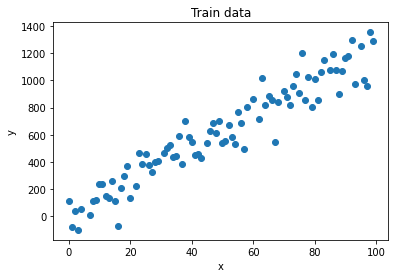

In [5]:
plt.scatter(X_train, y_train)
plt.title("Train data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

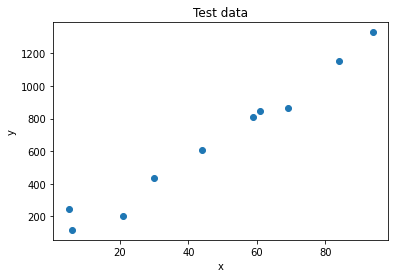

In [6]:
plt.scatter(X_test, y_test)
plt.title("Test data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [7]:
GRAMMAR_FILE = 'exp-grammar.bnf'
BNF_GRAMMAR = Grammar(path.join("grammars", GRAMMAR_FILE))

In [8]:
def write_stat(value, file_name):
    with open(file_name, "w") as write_file:
        write_file.write(str(value))


def read_stat(file_name):
    with open(file_name, "r") as write_file:
        cnt = int(write_file.read())
    return cnt

In [9]:
### cold-start
with open("statistics.txt", "w") as write_file:
    write_file.write(str(0))

In [10]:
def fitness_eval(individual, points):
    #points = [X, Y]
    x = points[0]
    y = points[1]
    
    if individual.invalid == True:
        return np.NaN,
    try:
        pred = eval(individual.phenotype)
        # pred = eval(parse_(individual.phenotype))
    # except (FloatingPointError, ZeroDivisionError, OverflowError,
    #         MemoryError, ValueError):
    except Exception as e:
        cnt = read_stat("statistics.txt") + 1
        write_stat(cnt, "statistics.txt")
        # write_stat(e, "statistics.txt")
        return np.NaN,
    assert np.isrealobj(pred)
    
    try:
        fitness = 1/np.mean(np.absolute(y - pred))
    # except (FloatingPointError, ZeroDivisionError, OverflowError,
    #         MemoryError, ValueError):
    except Exception as e:
        # cnt = read_stat("statistics.txt") + 1
        write_stat(cnt, "statistics.txt")
        # write_stat(e, "statistics.txt")
        fitness = np.NaN
        
    if fitness == float("inf"):
        return np.NaN,
    
    return fitness,

In [11]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)#, points=[X_train, Y_train])

# Tournament selection:
toolbox.register("select", ge.selTournament, tournsize=3)

# Single-point crossover:
toolbox.register("mate", ge.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", ge.mutation_int_flip_per_codon)


In [12]:
N_RUNS = 30
POPULATION_SIZE = 200
MAX_GENERATIONS = 150
P_CROSSOVER = 0.9
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)

HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 5
MIN_INIT_TREE_DEPTH = 1
MAX_TREE_DEPTH = 8
MAX_WRAPS = 0
CODON_SIZE = 255

In [13]:
maxListFitness = []
avgListFitness = []
minListFitness = []
stdListFitness = []

maxListSize = []
avgListSize = []
minListSize = []
stdListSize = []

In [14]:
for r in range(0, N_RUNS):
    # create initial population (generation 0):
    population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                            bnf_grammar=BNF_GRAMMAR, 
                                            min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                            max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                            max_tree_depth=MAX_TREE_DEPTH, 
                                            max_wraps=MAX_WRAPS,
                                            codon_size=CODON_SIZE
                                            )
    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)             
    # prepare the statistics object:
    #stats = tools.Statistics(key=lambda ind: ind.fitness.values if math.isnan(ind.fitness.values[0]) else None)#ind.fitness.values != np.inf else None)
    #stats = tools.Statistics(key=lambda ind: ind.fitness.values[0] if not math.isnan(ind.fitness.values[0]) else np.NaN)#ind.fitness.values != np.inf else None)
    stats = tools.Statistics(key=lambda ind: ind.fitness.values)# if not ind.invalid else (np.NaN,))#ind.fitness.values != np.inf else None)
    stats.register("avg", np.nanmean)
    stats.register("std", np.nanstd)
    stats.register("min", np.nanmin)
    stats.register("max", np.nanmax)
    
    # Which run are we on?
    print("\n\nCurrently on run", r, "of",N_RUNS)
    # perform the Grammatical Evolution flow:
    population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                          bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                          max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                          points_train=[X_train, y_train], 
                                          points_test=[X_test, y_test], 
                                          stats=stats, halloffame=hof, verbose=True)

    max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
    min_fitness_values, std_fitness_values = logbook.select("min", "std")
    
    # fitness_test = logbook.select("fitness_test")
    #best_ind_length = logbook.select("best_ind_length")
    # avg_length = logbook.select("avg_length")
    # max_length = logbook.select("max_length")
    # selection_time = logbook.select("selection_time")
    # generation_time = logbook.select("generation_time")
    # gen, invalid = logbook.select("gen", "invalid")ssssss

    # Save statistics for this run:
    avgListFitness.append(mean_fitness_values)
    stdListFitness.append(std_fitness_values)
    minListFitness.append(min_fitness_values)
    maxListFitness.append(max_fitness_values)

    # avgListSize.append(meanSizeValues)
    # stdListSize.append(stdSizeValues)
    # minListSize.append(minSizeValues)
    # maxListSize.append(maxSizeValues)

    best = hof.items[0].phenotype # parser to change the individual 
    # best = parse_(hof.items[0].phenotype) # parser to change the individual 
    print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
    print("\nTraining Fitness: ", hof.items[0].fitness.values[0])
    print("Depth: ", hof.items[0].depth)
    print("Length of the genome: ", len(hof.items[0].genome))
    print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')                            



Currently on run 0 of 30
gen	invalid	avg       	std        	min        	max       	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	0.00135573	0.000636899	5.39977e-14	0.00324625	1.0798e-12  	19             	8.29      	22        	0             	0.00893331     
1  	65     	0.00164616	0.000402762	0          	0.00222082	0.00173312  	9              	6.51      	26        	0.00120735    	0.049875       
2  	40     	0.00179912	0.00027518 	0          	0.00284383	0.00192605  	16             	7.555     	23        	0.00107288    	0.0181582      
3  	30     	0.00188841	0.000406227	0          	0.00304219	0.00199046  	15             	9.265     	32        	0.00130677    	0.021565       
4  	15     	0.00202939	0.000482548	0          	0.00317526	0.00205932  	17             	11.75     	33        	0.00113368    	0.021497       
5  	15     	0.00204557	0.000653205	0          	0.00324625	0.00212178  	10             	12.185    	29        	0.00102139    	0.0210993

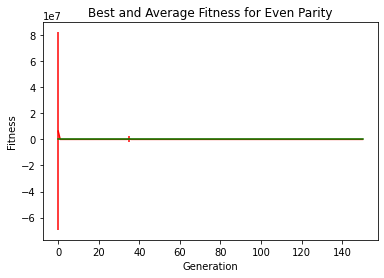

In [ ]:
#plot statistics:
x = np.arange(0, MAX_GENERATIONS+1)
avgArray = np.array(avgListFitness)
stdArray = np.array(stdListFitness)
minArray = np.array(minListFitness)
maxArray = np.array(maxListFitness)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Best and Average Fitness for Even Parity')
plt.errorbar(x, avgArray.mean(0), yerr=stdArray.mean(0),label="Average",color="Red")
plt.errorbar(x, minArray.mean(0), yerr=minArray.std(0),label="Best", color="Green")
plt.show()

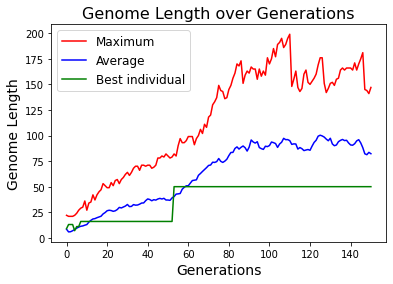

In [111]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()